
<img src="banner.png" >

# Proyecto semana 7: Aprendizaje por refuerzo

<!-- En esta semana, tendrán que utilizar el aprendizaje por refuerzo para completar una tarea propuesta. **En concreto, deberán entrenar un modelo de aprendizaje para que el robot sea capaz de recorrer su entorno y llegar a un objetivo deseado.** 

En el laboratorio de la semana 6 del curso tuvieron la oportunidad de entrenar un algoritmo de aprendizaje por refuerzo para entrenar a su robot y que alcance una posición deseada de manera autónoma. En este proyecto se les pedirá que utilicen los mismos principios presentados en dicho laboratorio, pero en otro escenario.
Especialmente tendrán que entrenar a su robot para resolver un laberinto con la siguiente forma:



<img src="Figure_2.PNG" width="500">

Su objetivo será entrenar a su robot para llegar la posición objetivo en la esquina superior derecha del ambiente. **Para esto deberán diseñar:**

•	La discretización del ambiente

•	Las recompensas que recibe el agente en cada estado de su discretización

•	La tasa de aprendizaje

•	 La rutina de entrenamiento (recuerde que usted puede ir entrenando progresivamente a su robot)

De acuerdo con lo establecido en la rúbrica de la semana 1, la calificación de su implementación se basará en la aplicación de su entrenamiento en 4 escenarios específicos de los uno de ellos se mantendrá oculto. Los escenarios (incluyendo el desconocido) consisten en ubicar al robot en diferentes ubicaciones iniciales en el laberinto:

 -->


In [140]:
# Importar librerías
import gym
import random
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Codigo para modificar ambiente discretizado

A continuación presentamos el codigo que se importaba en el laboratorio de la semana 6 para entrenar el modelo discretizado.
Su objetivo es modificarlo de acuerdo con el escenario propuesto, de forma que logre que el robot pueda resolver el laberinto propuesto. **Es decir,  usted debe definir que número de filas y columnas tendrá su ambiente discretizado, que recompensas se obtienen en los distintos estados, y como se definen dichas recompensas**

**USTED DEBE MODIFICAR ESTE CÓDIGO !!!** 

In [141]:
# Este es el codigo que se improtaba en el laboratorio de la semana 6 para entrenar el modelo discretizado.

import gym
import random
from gym import error, spaces, utils
from gym.utils import seeding

from copy import deepcopy
import numpy as np

class RobotEnv(gym.Env):
    '''Clase que define como se interactua con el modelo discretizado del ambiente.
    '''
    # Las observaciones del ambiente son parte de una lista
    def observation(self, state):
        return state[0] * self.cols + state[1]

    def __init__(self, p_wind=0.0, obstaculos=[], pos_inicial = [1,1]):
        self.obstaculos = obstaculos
        # Se define el número de filas del entorno discreto
        self.rows = 21 #5
        # Se define el númeto de columnas del entorno discreto
        self.cols = 21 #5
        # Se define el punto inicial del robot, 
        # PUEDE MODIFICAR ESTA POSICION INICIAL PARA LOS DISTINTOS ESCENARIOS PROPUESTOS
        self.start = pos_inicial #[1,1] #pos_inicial [190,10] [10,190] pero al escalar quedan [1,1] [19,1] [1,19]
        # Se define la posición del objetivo en el entorno discretizado
        self.goal = [19,19]
        self.current_state = None
        # variable de viento que no se usa en este laboratorio
        self.wind = False
        self.p_wind = p_wind

        # Mostrar el mapa discreto
        self.map = np.zeros((self.rows, self.cols), dtype=object)
        self.map[:] = '-'
        self.map[0, 1:-1] = 'X'
        # self.map[0,0] = 'o'
        self.map[self.goal[0],self.goal[1]] = 'G'

        # Hay cuatro acciones: arriba, abajo, izquierda y derecha
        self.action_space = spaces.Discrete(4)

         # la observación es la coordenada x, y de la cuadrícula
        self.observation_space = spaces.Discrete(self.rows*self.cols)

        self.normal_reward = 0

    # Accion de dar un paso
    def step(self, action):
        new_state = deepcopy(self.current_state)

        if action == 0: #derecha
            new_state[1] = min(new_state[1]+1, self.cols-1)
        elif action == 1: #abajo
            new_state[0] = max(new_state[0]-1, 0)
        elif action == 2: #izquierda
            new_state[1] = max(new_state[1]-1, 0)
        elif action == 3: #arriba
            new_state[0] = min(new_state[0]+1, self.rows-1)
        else:
            raise Exception("Invalid action.")

        # Variable de viento, no necesaria
        #self.wind = False


        # actualizar el mapa
        self.map[self.current_state[0], self.current_state[1]] = '-'
        self.map[new_state[0], new_state[1]] = 'o'

        # Actualizar estado
        self.current_state = new_state

        # DEFINICION DE RECOMPENSAS
        reward = -1
        is_terminal = False
        # definir recompensas si el robot va hacia alguna unbicación con obstaculos
        for ob in self.obstaculos:
            if self.current_state[0]== ob[0] and self.current_state[1]== ob[1]:
                reward = -50
                is_terminal = True
        # Definir recompensa cuando llega al objetivo definido
        if self.current_state[0] == self.goal[0] and self.current_state[1] == self.goal[1]:
            reward = 10000
            is_terminal = True
            # print("Se ha alcanzado el objetivo")
            # self.normal_reward = -0.01 # penalizar el movimiento una vez se llega al objetivo
            
        # se retorna la obsercación, la recompensa, si es un estado final, si hat viento, estado actual
        return self.observation(self.current_state), reward, is_terminal, {"wind": self.wind},self.current_state

    def reset(self):
        # Reiniciar posiciones
        self.current_state = self.start

        # Reiniciar mapa
        self.map = np.zeros((self.rows, self.cols), dtype=object)
        self.map[:] = '-'
        for ob in self.obstaculos:
            self.map[ob[0],ob[1]]= 'X'
        self.map[self.current_state[0],self.current_state[1]] = 'o'
        self.map[self.goal[0],self.goal[1]] = 'G'

        return self.observation(self.current_state)

    def render(self, mode='human'):
        print(np.flip(self.map,0))
        with open('map.txt', 'w') as f:
            for row in self.map:
                f.write(' '.join(row) + '\n')

    def close(self):
        pass


## ¿Cómo interactuar con el mapa discretizado?


**Su objetivo será entrenar a nuestro agente para que llegue a la posición deseada en el entorno discretizado.  Para ello, el robot tiene cuatro acciones posibles: moverse hacia la derecha, izquierda, arriba o abajo. Nuestro objetivo será que, a partir de estas recompensas, nuestro robot aprenda a llegar de forma autónoma a la posición deseada evitando los obstáculos. Es decir, que aprenda a obtener la máxima recompensa posible.**


**DEBE REVISAR QUE PARAMETROS DESEA MODIFICAR !!!**

In [142]:
np.array([ [20,50], [100,100], [100, 20], [100, 50], [125, 75], [150, 150], [150,20], [150,180],[75,100],
                         [50,125], [100, 125],[150,25], [75,160],[180,100],[125,190]])//10

array([[ 2,  5],
       [10, 10],
       [10,  2],
       [10,  5],
       [12,  7],
       [15, 15],
       [15,  2],
       [15, 18],
       [ 7, 10],
       [ 5, 12],
       [10, 12],
       [15,  2],
       [ 7, 16],
       [18, 10],
       [12, 19]])

In [143]:
# Puede utilizar esta linea de código para definr la ubicación de los obstaculos, o puede hacerlo directamente en la clase 
ubicacion_obstaculos_discreto_original = [[ 2,  5],
                                [10, 10],
                                [10,  2],
                                [10,  5],
                                [12,  7],
                                [15, 15],
                                [15,  2],
                                [15, 18],
                                [ 7, 10],
                                [ 5, 12],
                                [10, 12],
                                [15,  2],
                                [ 7, 16],
                                [18, 10],
                                [12, 19]]


def crear_marco(rows=21, cols=21):
    
    marco = []
    
    # Agregar bordes superior e inferior
    for j in range(cols):
        marco.append([0, j])  # Borde superior
        marco.append([rows-1, j])  # Borde inferior
    
    # Agregar bordes laterales
    for i in range(1, rows-1):  # Excluimos esquinas para no duplicar
        marco.append([i, 0])  # Borde izquierdo
        marco.append([i, cols-1])  # Borde derecho
    
    return marco

def expandir_obstaculos(obstaculos_base, rows=21, cols=21):
    obstaculos_expandidos = []
    # Direcciones para crear puntos alrededor del centro (patrón hexagonal)
    direcciones = [
        [-1, -1],  # arriba-izquierda
        [-1, 0],   # arriba
        [-1, 1],   # arriba-derecha
        [0, -1],   # izquierda
        [0, 1],    # derecha
        [1, -1],   # abajo-izquierda
        [1, 0],    # abajo
        [1, 1]     # abajo-derecha
    ]
    
    for centro in obstaculos_base:
        # Agregar el centro original
        obstaculos_expandidos.append(centro)
        # Agregar los 6 puntos alrededor si están dentro de los límites
        for dx, dy in direcciones:
            nuevo_x = centro[0] + dx
            nuevo_y = centro[1] + dy
            # Verificar que el nuevo punto está dentro de los límites
            if (0 <= nuevo_x < rows and 
                0 <= nuevo_y < cols and 
                [nuevo_x, nuevo_y] not in obstaculos_expandidos):
                obstaculos_expandidos.append([nuevo_x, nuevo_y])
                # print(f"Agregado punto: [{nuevo_x}, {nuevo_y}]")
    
    return obstaculos_expandidos

# Expandir la lista original
marco = crear_marco()
obstaculos_expandidos = expandir_obstaculos(ubicacion_obstaculos_discreto_original)
ubicacion_obstaculos_discreto = obstaculos_expandidos + marco


# ubicacion_obstaculos_discreto = [ [20,50], [100,100], [100, 20], [100, 50], [125, 75], [150, 150], [150,20], [150,180],[75,100],
#                          [50,125], [100, 125],[150,25], [75,160],[180,100],[125,190]]

In [144]:
any(num >= 21 for sublist in ubicacion_obstaculos_discreto for num in sublist)

False

In [145]:
len(ubicacion_obstaculos_discreto)

202

A continuación se presenta un pequeño ejemplo de como interactuar con el entorno. En este se utilizan las funciones estándar de los entornos de gym como:

* $\texttt{.reset()}$: Para reiniciar el entorno.
* $\texttt{.step(action)}$: Para ejecutar un paso en el entrono con una acción dada por parámetro, la acción indica el movimiento del robot en un entorno dividido en cuadrantes **(0=Derecha, 1=Abajo, 2=Izquierda, 3=arriba)**. 

> Este método retorna:
*   **Nuevo estado (int)**: Posición del agente en el mapa.
*   **Recompensa (int)**: Recompensa dada por la transición de estado (-1 para cualquier movimiento, -100 si se choca con un obstaculo, y 100 si llega al objetivo)
*   **Bandera de estado terminal (bool)**: Bandera booleana que indica si es un estado terminal.





$\texttt{.render()}$: Para renderizar en consola el entorno*

\* Opcional: No es necesario renderizar, especialmente cuando realice un gran número de simulaciones

In [165]:



# Objeto del entorno
env = RobotEnv(obstaculos= ubicacion_obstaculos_discreto, p_wind=0.0, pos_inicial=[15,10])

# Ciclo de 10 episodios
for i in range(1):
    # Nuevo episodio
    print('------------------------------')
    print('          EPISODE ' + str(i))
    print('------------------------------')
    time.sleep(1)
    clear_output(wait=True)

    # Se reinicia el entorno
    env.reset()
    done = False
    t_lim = 1
    t = 0
    while not done and t<t_lim:
      # Se selecciona una acción aleatoria del espacio de acciones
      action = env.action_space.sample()

      # Se da un paso en la acción seleccionada
      state, reward, done, info,_ = env.step(action)

      # Se renderiza el entorno
      env.render()
    #   with open('map.txt', 'w') as f:
    #       for row in np.flip(env.map, ):
    #           f.write(''.join(row) + '\n')

      # Se imprime información relevante
      print('State: '+str(state))
      print('Reward: '+str(reward))
      print('Action: '+str(action))
      time.sleep(1)
      clear_output(wait=True)
      t+=1
          
env.close()

[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-'
  '-' 'G' 'X']
 ['X' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-'
  '-' '-' 'X']
 ['X' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-'
  '-' '-' 'X']
 ['X' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' '-' '-' '-' '-' '-' 'o' '-' '-' '-' '-' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  'X' 'X' 'X']
 ['X' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' '-' '-' '-' '-'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' '-' '-' 'X' 'X' 'X' 'X' 'X' '-' '-' '-' '-'
  '-' '-' 'X']
 ['X' 'X' 'X' 'X' 'X'

## Entrenar aprendizaje por refuerzo

En el labortatorio de la semana 6 usamos un **método de Monte Carlo con múltiples visitas.** En él, se guarda una recompensa esperada por cada par estado-acción, de forma que el robot puede saber qué recompensa esperar si ejecuta una acción determinada en cada estado. El objetivo es que, a partir de esta información, el robot sea capaz de tomar la acción que aumente su recompensa esperada en cada estado. 

**Usted puede utilizar este mismo método o cualquier otro de su elección para el desarrollo del proyecto !!!**


Lo primero a realizar es crear la tabla con los valores de la funcion de valor de los pares estado-accion (q(s,a)), y el diccionario donde se guardaran los retornos obtenidos para cada estado. Esto se hace en la siguiente linea de codigo.  

In [147]:
def crear_q():
    # Hay 25 estados, correspondientes a las 25 posiciones en la grilla discreta
    #estados = [i for i in range(25)]
    estados = [i for i in range(441)]
    acciones = [0,1,2,3]
    Q = {}
    for i in range(len(estados)):
        Q[estados[i]] = {}
        for a in acciones:
            Q[estados[i]][a] = 0
    return Q

def crear_retorno():
    estados = [i for i in range(441)]
    acciones = [0,1,2,3]
    Q = {}
    for i in range(len(estados)):
        Q[estados[i]] = {}
        for a in acciones:
            Q[estados[i]][a] = []
    return Q

        

Ahora creamos la función que define cómo el agente decide qué acciones tomar en cada estado durante la fase de entrenamiento. Para ello, usamos un algoritmo Epsilon Greedy, en el que el agente selecciona la acción que maximiza la recompensa esperada con una probabilidad alta, pero se crea una probabilidad de que el agente utilice una estrategia no óptima. Esto se hace para que el robot explore acciones que posiblemente no haya utilizado antes. De este modo, se muestra el dilema entre exploración y explotación en los algoritmos de aprendizaje por refuerzo.


In [148]:
def seleccionar_accion(Q, estado, epsilon):
    mejor_accion = 0
    mejor_valor = Q[estado][0]
    for i in range(4):
        if Q[estado][i] >= mejor_valor:
            mejor_accion = i
            mejor_valor = Q[estado][i]
    acciones = [epsilon/4 for i in range(4)]
    acciones[mejor_accion] = epsilon/4 + (1-epsilon)
    accion_esc = np.random.choice([0,1,2,3], p = acciones)
    # print(accion_esc)
    return accion_esc
    
    

In [279]:
# creamos una función encargada de crear los episodios de entrenamiento del robot

def crear_episodio(p_viento, Q, epsilon, pos_inicial):
    # Se reinicia el entorno
    # Vea que tiene la opción de definir una ubicación inicial como parametro
    env = RobotEnv(obstaculos= ubicacion_obstaculos_discreto, pos_inicial= pos_inicial)
    # print(env.start)
    env.reset()
    done = False
    estados = []
    recompensas = []
    viento = []
    acciones = []
    inicio = True
    state1 = 0
    state = 0
    retorno = 0
    tlim= 100
    t = 0
    while not done and t<500:
        # Se selecciona una acción aleatoria del espacio de acciones
        action = seleccionar_accion(Q,state,epsilon)
        acciones.append(action)
        estados.append(state)
        # Se da un paso en la acción seleccionada
        state, reward, done, info,_ = env.step(action)
        #estados.append(state1)
        recompensas.append(reward)
        #retorno += reward
        viento.append(info)
        t+= 1
        if done:
            # print('done')
            pass
    env.close()
    return estados,recompensas,viento, acciones
         

Dentro de nuestro algoritmo, vamos a crear una política que indicará al robot qué acción debe tomar en cada estado. El objetivo de la fase de entrenamiento del algoritmo de aprendizaje por refuerzo es crear esta política, de forma que el robot logre alcanzar el objetivo deseado.

In [150]:
def crear_politica():
    estados = [i for i in range(441)]
    acciones = [0,1,2,3]
    p = {}
    for i in range(len(estados)):
        p[estados[i]] = {}
        for a in acciones:
            p[estados[i]][a] = 1/4
    return p

Ahora creamos la función encargada de implementar el algoritmo de Monte Carlo de múltiples visitas. Puede leer la función para entender cómo actúa el algoritmo paso a paso.

In [151]:
def crear_retorno_multiple():
    estados = [i for i in range(441)]
    acciones = [0,1,2,3]
    Q = {}
    for i in range(len(estados)):
        Q[estados[i]] = {}
        for a in acciones:
            Q[estados[i]][a] = [0,0]
    return Q


**Note que modificamos la función de monte carlo de multiples visitas para que se pueda recibir por parametro la función de valor q que guarda los valores esperados de las recompensas por cada par estado-acción. Esto se hace para que puedan crear multiples episodios de entrenamiento de forma que se pueda ir actualizando progresivamente la tabla con los valores estimados de la recompensa de cada par estado-acción.**

In [152]:
import tqdm
# Note que agregamos la posibilidad de que la funcion reciva por parametro una  función de valor
#  q que guarda los valores esperados de las recompensas por cada par estado-acción -> funcion_q
def monte_carlo_multiple_visita(episodios, p_viento, gamma, epsilon, funcion_q = None, epsilon_decay = 0.99999, pos_inicial = [1,1]):
    #inicializar politica inicial
    politica = crear_politica()
    #inicializar funcion de valor de pares estado-accion q(s,a)
    # si no se recibe una funcion de valor, se crea una
    if funcion_q == None:
        funcion_q = crear_q()
    # inicializar lista de retornos para pares estado accion.
    retornos = crear_retorno_multiple()
    # print(len(retornos))
    recompensa_promedio = []
    acciones_promedio = []
    for e in tqdm.tqdm(range(episodios)):
        estados_ep, recompensas_ep, viento_ep, acciones_ep= crear_episodio(p_viento, funcion_q, epsilon, pos_inicial)
        epsilon = max(0.1, epsilon*epsilon_decay)
        #recompensa_promedio.append(retorno_ep)
        G = 0
        for esta in range(len(estados_ep)-1,-1,-1):
            G = G*gamma + recompensas_ep[esta]
            estado_actual = estados_ep[esta]
            accion_tomada = acciones_ep[esta]
            numero_retornos = retornos[estado_actual][accion_tomada][0]
            valor_retornos = retornos[estado_actual][accion_tomada][1]
            retornos[estado_actual][accion_tomada] = [numero_retornos+1, ((valor_retornos*numero_retornos)+G)/(numero_retornos+1)]
            funcion_q[estado_actual][acciones_ep[esta]] = retornos[estado_actual][accion_tomada][1]
        recompensa_promedio.append(G)
        acciones_promedio.append(acciones_ep)
        
    return funcion_q, recompensa_promedio, acciones_promedio

**A continuación, aplicamos nuestro algoritmo para entrenar a nuestro robot en el entorno discreto y generar las acciones óptimas que debe tomar.**

**DEBE MODIFICAR ESTE CÓDIGO DE ACUERDO A SU ESTRATEGIA DE ENTRENAMIENTO!!!**

In [153]:
Q_041, recompensa_041_iter, acciones_mo_041_iter = monte_carlo_multiple_visita(1,0.0,1.0,0.3, None, 0.99,[19,1])

100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
# Los parametros de la función son (numero de ejecuciones en el entrenamiento,
#                                   Probabilidad de viento (Por ahora no es necesario esto),
#                                   gamma (factor encargado de determinar la contribución de cada estado a la recompenza del episodio),
#                                   epsilo (tasa de aprendizaje del robot))
Q_041 = None
# pos_iniciales = [[18,16], [11,16], [3,16], [6,6], [14,10], [1,19], [19,1], [1,1]]
pos_iniciales = [[18,16], [15,10], [12,16], [6,6], [1,1]]
recompensa_041 = []
acciones_mo_041 = []
for pos_inicial in pos_iniciales:
    print('Posicion inicial: ', pos_inicial)
    if Q_041 is None:
        Q_041, recompensa_041_iter, acciones_mo_041_iter = monte_carlo_multiple_visita(200000,0.0,0.9,0.9, None, 0.9999, pos_inicial)
        recompensa_041.extend(recompensa_041_iter)
        acciones_mo_041.extend(acciones_mo_041_iter)
    else:
        print("Usando Q_041 previamente entrenado")
        Q_041, recompensa_041_iter, acciones_mo_041_iter = monte_carlo_multiple_visita(20000,0.0,0.9,0.9, Q_041, 0.9999, pos_inicial)
        recompensa_041.extend(recompensa_041_iter)
        acciones_mo_041.extend(acciones_mo_041_iter)
    # Q_041, recompensa_041, acciones_mo_041 = monte_carlo_multiple_visita(5000000,0.0,1.0,0.5, None, 0.99999, pos_inicial)
# Q_041, recompensa_041, acciones_mo_041 = monte_carlo_multiple_visita(5000000,0.0,1.0,0.5)

Posicion inicial:  [18, 16]


  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [00:42<00:00, 4657.58it/s]


Posicion inicial:  [15, 10]
Usando Q_041 previamente entrenado


100%|██████████| 20000/20000 [00:13<00:00, 1474.44it/s]


Posicion inicial:  [12, 16]
Usando Q_041 previamente entrenado


100%|██████████| 20000/20000 [00:15<00:00, 1330.54it/s]


Posicion inicial:  [6, 6]
Usando Q_041 previamente entrenado


100%|██████████| 20000/20000 [21:29<00:00, 15.51it/s]


Posicion inicial:  [1, 1]
Usando Q_041 previamente entrenado


100%|██████████| 20000/20000 [17:09<00:00, 19.43it/s] 


In [290]:
pos_intermedias = [[18,6], [5,18], [1,15], [3,8], [5,5]]
# recompensa_041 = []
# acciones_mo_041 = []
for pos_intermedia in pos_intermedias:
    print("Usando Q_041 previamente entrenado")
    Q_041, recompensa_041_iter, acciones_mo_041_iter = monte_carlo_multiple_visita(10000,0.0,0.7,0.9, Q_041, 0.9999, pos_intermedia)
    recompensa_041.extend(recompensa_041_iter)
    acciones_mo_041.extend(acciones_mo_041_iter)

Usando Q_041 previamente entrenado


100%|██████████| 10000/10000 [00:46<00:00, 215.42it/s]


Usando Q_041 previamente entrenado


100%|██████████| 10000/10000 [00:39<00:00, 255.77it/s]


Usando Q_041 previamente entrenado


100%|██████████| 10000/10000 [00:35<00:00, 279.16it/s]


Usando Q_041 previamente entrenado


100%|██████████| 10000/10000 [00:43<00:00, 228.09it/s]


Usando Q_041 previamente entrenado


100%|██████████| 10000/10000 [00:52<00:00, 190.86it/s]


Aca podemos ver la evolución de las recompensas recibidas durante la ejecución del entrenamiento.

In [287]:
# Q_041
len(recompensa_041)

345000

In [286]:
print(Q_041[40])

{0: -50.0, 1: -50.0, 2: -6.444616037680082, 3: -26.2}


In [291]:
# guardar Q
import pickle
with open('Q_041_with_intermediate.pkl', 'wb') as f:
    pickle.dump(Q_041, f)

In [ ]:
# # cargar Q
# with open('Q_041.pkl', 'rb') as f:
#     Q_041 = pickle.load(f)

Text(0.5, 0, 'Iteraciones')

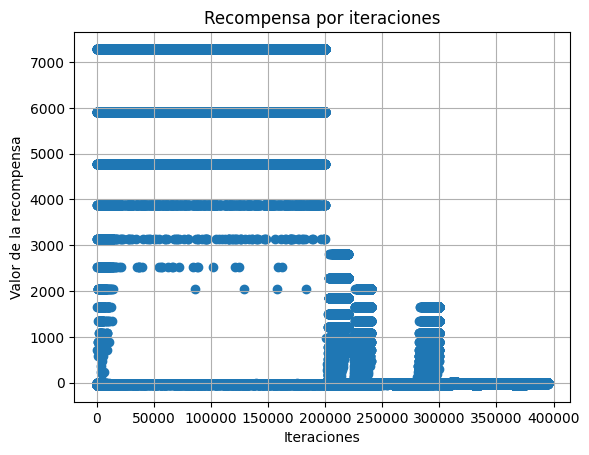

In [292]:
plt.scatter([i for i in range(len(recompensa_041))],recompensa_041)
plt.title('Recompensa por iteraciones')
plt.grid(True)
plt.ylabel('Valor de la recompensa')
plt.xlabel('Iteraciones')

A continuación podemos ver la politica optima encontrada por el robot para completar la tarea propuesta.

In [294]:
# Objeto del entorno
# [[18,6], [5,18], [1,15], [3,8], [5,5]]
env = RobotEnv(obstaculos= ubicacion_obstaculos_discreto, pos_inicial= [5,18])
estados = []
# Ciclo de 10 episodios
acciones = []
movimientos_coor = []
for i in range(1):
    # Nuevo episodio
    print('------------------------------')
    print('          EPISODE ' + str(i))
    print('------------------------------')
    time.sleep(1)
    clear_output(wait=True)

    # Se reinicia el entorno
    env.reset()
    # env.render()
    done = False
    state = 0
    iteraciones = 0
    while not done and iteraciones< 50:
      # Se selecciona una acción aleatoria del espacio de acciones
      action = seleccionar_accion(Q_041,state,0.0)
      # Se da un paso en la acción seleccionada
      acciones.append(action)
      state, reward, done, info, coordenadas = env.step(action)
      movimientos_coor.append(coordenadas)
      estados.append(state)
      # Se renderiza el etnrono
      env.render()

      # Se imprime información relevante
      if info['wind']:
        print('WIND!')
      print('State: '+str(state))
      print('Reward: '+str(reward))
      print('Action: '+str(action))
      time.sleep(1)
      clear_output(wait=True)
      iteraciones += 1

env.close()

[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-'
  '-' 'G' 'X']
 ['X' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-'
  '-' '-' 'X']
 ['X' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-'
  '-' '-' 'X']
 ['X' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' 'X' 'X' 'X'
  'X' 'X' 'X']
 ['X' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  'X' 'X' 'X']
 ['X' '-' '-' '-' '-' '-' 'X' 'X' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' '-' '-' '-' '-'
  'X' 'X' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' '-' '-' 'X' 'X' 'X' 'X' 'X' '-' '-' '-' '-'
  '-' '-' 'X']
 ['X' 'X' 'X' 'X' 'X'

KeyboardInterrupt: 

Ahora podemos ver gráficamente el orden en el que el robot recorre el entorno discreto.

In [353]:
lista = ['-' for i in range(40000)]
lista[0] = 0
for i in range(len(estados)-1):
    lista[estados[i]]= i+1


m = np.array([lista[40:50],lista[30:40],lista[20:30],lista[10:20],lista[0:10]])
# m = np.array([lista[20:25],lista[15:20],lista[10:15],lista[5:10],lista[0:5]])


print('Pasos realizados en el recorrido: \n')
print(m)


Pasos realizados en el recorrido: 

[['2' '-' '-' '-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
 ['1' '-' '-' '-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
 ['0' '-' '-' '-' '-' '-' '-' '-' '-' '-']]


## Simulador Robótico.

Una vez entrenado nuestro controlador a alto nivel mediante aprendizaje por refuerzo, aplicaremos estas acciones en nuestro entorno virtual de trabajo a lo largo del curso.

In [33]:
"""
Implimentación simulador robotico: Esta es una versión adaptada del simulador propuesto originalmente por: Paul O'Dowd y Hemma Philamore 
https://github.com/paulodowd/GoogleColab_Simple2DSimulator
"""


from math import *
import numpy as np
from random import shuffle, randrange
import sys

import matplotlib.pyplot as plt

"""
Creación de la clase que define los obstaculos. En nuestros escenarios los obstaculos tendran forma circular.
"""

class Obstacle_c: 
  # Se asigna una posición aleatoria dentro del entorno manteniendo una distancia con el centro (donde inicia el robot)
  def __init__(self, x_prop, y_prop, arena_size=200, radius=1, rot=0.0, max_obstacles=1):

    self.radius = radius


    rot_ang = rot * ((np.pi*2)/max_obstacles)
    
    rand_dist = np.random.uniform(0.1, .7) * (arena_size/2)
    #print('arena size',arena_size/2)
    if x_prop<0 and y_prop<0:
      self.x = (arena_size/2) + rand_dist*np.cos(rot_ang)
      self.y = (arena_size/2) + rand_dist*np.sin(rot_ang)
    else:
      self.x = x_prop
      self.y = y_prop





"""
Clase que define el funcionamiento de cada sensor de proximidad.
"""
class ProxSensor_c:

  # Posición global en xy del sensor
  x = 0
  y = 0
  theta = 0

  # Para guardar la ultima lectura 
  reading = 0

  # Localizar el sensor alrededor del cuerpo del robot
  offset_dist = 0
  offset_angl = 0

  # maximo rango de lectura en cm
  max_range = 20

  
  def __init__(self, offset_dist=5, offset_angl=0):
    self.offset_dist = offset_dist
    self.offset_angl = offset_angl


  def updateGlobalPosition(self, robot_x, robot_y, robot_theta ):

    # Dirección actual del sensor es la rotación del robot
    # mas la rotación predeterminada del sensor en relación
    # al cuerpo del robot.
    self.theta = self.offset_angl + robot_theta

    sensor_x = (self.offset_dist*np.cos(self.theta))
    sensor_y = (self.offset_dist*np.sin(self.theta))

 
    self.x = sensor_x + robot_x
    self.y = sensor_y + robot_y

    self.reading = -1

  def scanFor( self, obstruction ):

    # Escanear por posibles obstaculos
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance = distance - obstruction.radius


    # Si esta fuera de rango, no retorna nada
    if distance > self.max_range:
      return

    a2o = atan2( ( obstruction.y - self.y), (obstruction.x-self.x ))

    angle_between = atan2( sin(self.theta-a2o),  cos(self.theta-a2o) )
    angle_between = abs( angle_between )

    
    if angle_between > np.pi/8:
      return

  
    if self.reading < 0:
      self.reading = distance


    if self.reading > 0:
      if distance < self.reading:
        self.reading = distance





"""
Clase que define el funcionamiento del robot
"""
class Robot_c:


  def __init__(self, x=50,y=50,theta=np.pi, objetivo = [190,190,5]):
    self.x = x
    self.y = y
    self.theta = np.pi/4# theta
    self.stall = -1 # evaluar colisiones

    self.desire = -1
    self.score = 0
    self.radius = 5 # 5cm radio
    self.wheel_sep = self.radius*2 # Mismo tamaño de rueda a cada lado
    self.vl = 0
    self.vr = 0
    self.objetivo = objetivo
    # ubicación de los sensores en radianes
    self.sensor_dirs = [5.986479,
                        5.410521,
                        4.712389,
                        3.665191,
                        2.617994,
                        1.570796,
                        0.8726646,
                        0.296706,
                        ]

    self.prox_sensors = [] 
    for i in range(0,8):
      self.prox_sensors.append( ProxSensor_c(self.radius, self.sensor_dirs[i]) )


  def updatePosition( self, vl, vr ):
    '''
    if vl > 1.0:
      vl = 1.0
    if vl < -1.0:
      vl = -1.0
    if vr > 1.0:
      vr = 1.0
    if vr < -1.0:
      vr = -1.0

    self.vl = vl
    self.vr = vr
    '''
    self.stall = -1

    # Matriz del movimiento del robot
    r_matrix = [(vl/2)+(vr/2),0, (vr-vl)/self.wheel_sep]

    # Matriz para convertir referencia local a referencia global
    k_matrix = [
                [ np.cos(self.theta),-np.sin(self.theta),0],
                [ np.sin(self.theta), np.cos(self.theta),0],
                [0,0,1]
               ]

    result_matrix = np.matmul( k_matrix, r_matrix)

    self.x += result_matrix[0]
    self.y += result_matrix[1]
    self.theta += result_matrix[2]

    for prox_sensor in self.prox_sensors:
      prox_sensor.updateGlobalPosition( self.x, self.y, self.theta )



  
  def updateSensors(self, obstruction ):

    for prox_sensor in self.prox_sensors:
      prox_sensor.scanFor( obstruction )

  def collisionCheck(self, obstruction ):
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance -= self.radius
    distance -= obstruction.radius
    if distance < 0:
      self.stall = 1
      angle = atan2( obstruction.y - self.y, obstruction.x - self.x)
      self.x += distance * np.cos(angle)
      self.y += distance * np.sin(angle)

  def updateScore(self):
    # Se define la metrica a usar para evaluar el desempeño.
    new_score = 0
    if self.desire == -1:
        if abs(self.x -self.objetivo[0]) < self.objetivo[2] and abs(self.y -self.objetivo[1]) < self.objetivo[2] :
            new_score = 100
            self.desire = 1
        if self.stall == 1:
            new_score -= 5
    self.score += new_score


### Ahora creamos el controlador a bajo nivel encargado de llevar al robot a una posicion especifica

**Puede usar el código como esta o modificarlo, es su elección!!!**

In [359]:
#
# Crear un controlador con def update(self, robot):
#
#

#
class Controller_c:

  # Esta función es llamada repetidamente para definir las acciones que debe tomar el robot.
  def __init__(self):
    self.giroAntes = False
    self.angulo = 0

  def update( self, my_robot , objetivo, ubicado = False):

    vect_obj = np.array([objetivo[0]-my_robot.x, objetivo[1]-my_robot.y])
    vect_rob = np.array([np.cos(my_robot.theta), np.sin(my_robot.theta) ])
    distancia_angulo = (vect_rob[1]*vect_obj[0] -vect_rob[0]*vect_obj[1] )/(np.sqrt(vect_rob[0]**2 + vect_rob[1]**2))
    coseno = np.dot(vect_obj, vect_rob)/(np.linalg.norm(vect_rob)*np.linalg.norm(vect_obj))
    coseno = np.clip(coseno, -1, 1)
    angulo = np.arccos(coseno) * np.sign(distancia_angulo)
    # my_robot.desire es -1 si no ha llegado al objetivo, 1 de lo contrario
    if my_robot.desire == -1:
      if ubicado:
          vl = 1
          vr = 1
      else:
          if angulo >  0.05:
              vl =0.1#*abs(angulo)
              vr = -0.1#*abs(angulo)
          elif angulo < - 0.02:
              vl = -0.1#*abs(angulo)
              vr = 0.1#*abs(angulo)
          else:
              ubicado = True
              vl = 1
              vr = 1
    else:
      vl = 0
      vr = 0
    
      
    

    # El controlador siempre debe retornar esto, asi que no cambie la siguente linea
    return vl, vr



Volvemos a ejecutar la politica optima del robot, encontrada a alto nivel por el aprendizaje por refuerzo 


In [360]:
# Objeto del entorno
env = RobotEnv(obstaculos= ubicacion_obstaculos_discreto)
estados = []
# Ciclo de 10 episodios
acciones = []
movimientos_coor = []
for i in range(1):
    # Nuevo episodio
    print('------------------------------')
    print('          EPISODE ' + str(i))
    print('------------------------------')
    time.sleep(1)
    clear_output(wait=True)

    # Se reinicia el entorno
    env.reset()
    done = False
    state = 0
    iteraciones = 0
    while not done and iteraciones< 200:
      # Se selecciona una acción aleatoria del espacio de acciones
      action = seleccionar_accion(Q_041,state,0.0)
      # Se da un paso en la acción seleccionada
      acciones.append(action)
      state, reward, done, info, coordenadas = env.step(action)
      movimientos_coor.append(coordenadas)
      estados.append(state)
      # Se renderiza el etnrono
      env.render()

      # Se imprime información relevante
      if info['wind']:
        print('WIND!')
      print('State: '+str(state))
      print('Reward: '+str(reward))
      print('Action: '+str(action))
      time.sleep(1)
      clear_output(wait=True)
      iteraciones += 1

env.close()

[['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' 'o']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' 'X' '-' '-'
  'X' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' 'X' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' 'X']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' 'X' '-' '-' 'X' '-' '-' '-' '-' 'X' '-' 'X' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'
  '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-'

In [361]:
m = np.array([lista[20:25],lista[15:20],lista[10:15],lista[5:10],lista[0:5]])
print(m)

[['1' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-']
 ['0' '-' '-' '-' '-']]




**Dentro del contexto del proyecto tendrán que modificar el código que asocia los estados discretizados que desarrollo en su modelo con los centros del mapa original en donde se encuentra el agente** 

**TIENE QUE MODIFICAR ESTE CODIGO!!!!**


In [372]:
# Creamos la matriz que nos asocia los centros del ambiente original con las coorednadas del ambiente discreto
# centros = [[[i,j] for i in range(10,91,20)] for j in range(10,91,20)]
centros = [[[i,j] for i in range(10,380,10)] for j in range(10,380,10)]

# Ahora guardamos las ubicaciones progresivas de acuerdo a la politica optima dada por el aprendizaje por refuerzo
objetivos_progresivos =[]
for mov in range(len(movimientos_coor)):
    #print(centros[movimientos_coor[mov][0]][movimientos_coor[mov][1]])
    objetivos_progresivos.append(centros[movimientos_coor[mov][0]][movimientos_coor[mov][1]])
print("Objetivos progresivos: ",objetivos_progresivos)

# PUEDE BORRAR ESTA LINEA PARA SUS EJECUCIONES
# objetivos_progresivos = [
#     [20, 20],   # Esquina inferior izquierda
#     [20, 180],  # Esquina superior izquierda 
#     [180, 20],  # Esquina inferior derecha
#     # Puedes agregar más posiciones según necesites
# ]



Objetivos progresivos:  [[10, 20], [10, 30], [10, 40], [20, 40], [30, 40], [40, 40], [50, 40], [50, 50], [50, 60], [50, 70], [60, 70], [70, 70], [70, 80], [70, 90], [80, 90], [80, 100], [90, 100], [90, 110], [90, 120], [100, 120], [100, 130], [100, 140], [110, 140], [110, 150], [120, 150], [120, 160], [120, 170], [130, 170], [130, 180], [140, 180], [140, 190], [150, 190], [150, 200], [160, 200], [170, 200], [180, 200], [190, 200], [200, 200]]


In [373]:
len(movimientos_coor)

38

In [375]:
movimientos_coor[-1]

[19, 19]

Definimos la ubicación de los obstaculos presentes en el ambiente

In [30]:
ub_obstacles = np.array([ [20,50], [100,100], [100, 20], [100, 50], [125, 75], [150, 150], [150,20], [150,180],[75,100],
                         [50,125], [100, 125],[150,25], [75,160],[180,100],[125,190]])




num_obstacles = len(ub_obstacles)

In [251]:
# ub_obstacles//10

In [31]:
def hacer_reja():
    inicio = 0
    fin = 200
    ubicaciones = []
    for i in range(inicio,fin):
        ubicaciones.append([inicio,i])
        ubicaciones.append([fin,i])
        ubicaciones.append([i,fin])
        #if i> inicio+50:
        ubicaciones.append([i, inicio])
    return ubicaciones



ub_obstacles2 = hacer_reja()
num_obstacles2 = len(ub_obstacles2)

Por último, implementamos nuestra combinación de control a alto y bajo nivel en el entorno final del robot. Como podrá ver, utilizamos el controlador definido anteriormente junto con los objetivos progresivos detectados por el algoritmo de aprendizaje por refuerzo.

**TIENE QUE MODIFICAR ESTE CÓDIGO PARA UBICAR AL ROBOT EN LAS DISTINTAS POSICIONES INICIALES DESCRITAS ANTERIORMENTE**

C:\Users\vic_p\AppData\Local\Temp\ipykernel_23128\2001434693.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  gui_dir, = ax.plot([], [], 'r-', c="yellow")
C:\Users\vic_p\AppData\Local\Temp\ipykernel_23128\2001434693.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  gui_sensor = ax.plot( *[[],[]]*num_sensors,'r-', c="red")
C:\Users\vic_p\AppData\Local\Temp\ipykernel_23128\2001434693.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  gui_obstacles, = ax.plot([],[],'bo', ms=radio_obstaculos*2, c="orange")
C:\Users\vic_p\AppData\Local\Temp\ipykernel_23128\2001434693.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument an

NameError: name 'Controller_c' is not defined

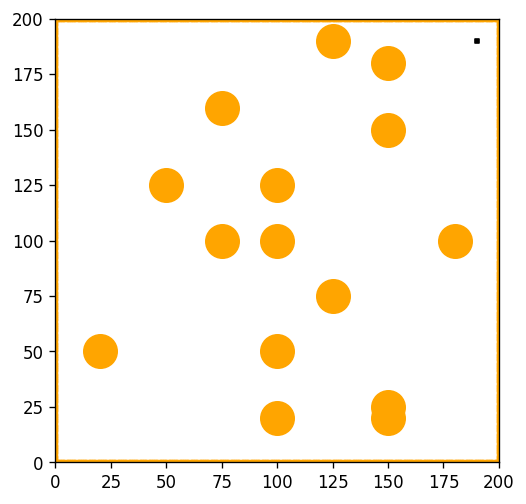

In [34]:
# Ahora guaramos las ubicaciones de los obstaculos de acuerdo al entorno discretizado
# obstacles_xy = []
# for ob in ubicacion_obstaculos_discreto:
#    obstacles_xy.append(centros[ob[0]][ob[1]])
obstacles_xy = ub_obstacles

#print('Los obstaculos del entorno estan en: ', obstacles_xy)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128


numframes = 1#600
arena_width = 200
#num_obstacles = 3
num_sensors = 8



fig = plt.figure(dpi=120)
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, arena_width), ylim=(0, arena_width))



objetivo = [190, 190,2] # 2 es el radio del objetivo
ax.scatter(objetivo[0], objetivo[1], s = 1*objetivo[2]**2, color = "black", marker='s')
#my_robot = Robot_c(10,10,np.random.random()*np.pi*2, objetivo)

## Defina la posicion inicial del robot
my_robot = Robot_c(10,10,np.pi/4, objetivo)

gui_robot, = ax.plot([], [], 'bo', ms=my_robot.radius*2)
gui_robot.set_data([], [])
gui_dir, = ax.plot([], [], 'r-', c="yellow")
gui_sensor = ax.plot( *[[],[]]*num_sensors,'r-', c="red")

radio_obstaculos = 10
radio_obstaculos2 = 1.25

gui_obstacles, = ax.plot([],[],'bo', ms=radio_obstaculos*2, c="orange")
gui_obstacles2, = ax.plot([],[],'bo', ms=radio_obstaculos2*2, c="orange")


#gui_obstacles, = ax.plot([],[],'bo', ms=2.25, c="orange")

obstacles = []
num_obstacles = 0
#obstacles_xy = [[50,50],[90,10],[10,90]]
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c(obstacles_xy[i][0],obstacles_xy[i][1], arena_width, radio_obstaculos, i, num_obstacles) )
  #obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )

obstacles_xy = np.asarray( obstacles_xy, dtype=float)
gui_obstacles.set_data( obstacles_xy[:,0], obstacles_xy[:,1]  )

obstacles_xy2 =[]
for i in range( num_obstacles2 ):
  obstacles.append( Obstacle_c(ub_obstacles2[i][0],ub_obstacles2[i][1], arena_width, radio_obstaculos2, i, num_obstacles2) )
  obstacles_xy2.append( [obstacles[num_obstacles+i].x, obstacles[num_obstacles+i].y] )

obstacles_xy2 = np.asarray( obstacles_xy2, dtype=float)
gui_obstacles2.set_data( obstacles_xy2[:,0], obstacles_xy2[:,1]  )

# ¡Una instancia de nuestro controlador!
my_controller = Controller_c()
ind_objetivo= 0
objetivo_actual = objetivos_progresivos[ind_objetivo]

def animate(i):

    global ax, fig, objetivos_progresivos, objetivo_actual, ind_objetivo


    # Usar el controlador para establecer nuevas velocidades del motor en
    # rango [-1.0:+1.0]
    if abs(my_robot.x-objetivo_actual[0]) < 0.2 and abs(my_robot.y-objetivo_actual[1]) < 0.2:
      #if objetivo_actual[0] != objetivo[0] and objetivo_actual[1] != objetivo[1]: 
      ind_objetivo +=1
      if ind_objetivo< len(objetivos_progresivos):
        objetivo_actual = objetivos_progresivos[ind_objetivo]
    #print(objetivo_actual)
    vl, vr = my_controller.update( my_robot, objetivo_actual )

    # Update robot position, check for collision,
    # then update sensors.
    my_robot.updatePosition(vl, vr)
    for obstacle in obstacles:
      my_robot.collisionCheck( obstacle )
      my_robot.updateSensors( obstacle )

    # Dibuja el robot, cambia el color para la colisión
    gui_robot.set_data([my_robot.x], [my_robot.y])
    if my_robot.stall == 1:
      gui_robot.set_color("red")
    else:
      gui_robot.set_color("blue")

    # Dibuja un pequeño indicador para que podamos ver qué
    # mira el robot
    tx = my_robot.x + (my_robot.radius*1.4*np.cos(my_robot.theta))
    ty = my_robot.y + (my_robot.radius*1.4*np.sin(my_robot.theta))
    gui_dir.set_data( (my_robot.x,tx), (my_robot.y, ty) )



    # Actualiza la puntuación actual en el título
    my_robot.updateScore()
    #ax.set_title('Score: {0:f}'.format( my_robot.score ))

    return gui_robot,

plt.close()
ani = animation.FuncAnimation(fig, animate, frames=numframes, interval=20, blit=True)
ani


#plt.show(ani)

# Entrega final

Finalmente, recuerde que debe entregar un PDF con la explicación del diseño de la estrategia heurística y el análisis de los resultados obtenidos, donde analice los siguientes aspectos:
Resultados, presente conclusiones sobre el desempeño del modelo, detecte fallos en el controlador utilizado y proponga posibles mejoras. Además, debe responder a las siguientes preguntas:


* ¿Qué restricciones impone utilizar un algoritmo de aprendizaje por refuerzo para planear la trayectoria del robot?
* ¿Qué pasaría si se agregan mas obstaculos que el robot no conocia en su fase de entrenamiento?
* ¿Cómo podría complementar este código con los diseñados en las semanas 3 y 5 para resolver entornos mas complejos?


